In [1]:
import asdf
import numpy as np
af = asdf.open('J121930+494052.asdf')
wave = np.array(af['wave'])
wave = np.array(wave, dtype="<f8")
flux = np.array(af['flux'])
flux = np.array(flux, dtype="<f8")
err = np.array(af['err'])
err = np.array(err, dtype="<f8")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(-0.1, 1.1)

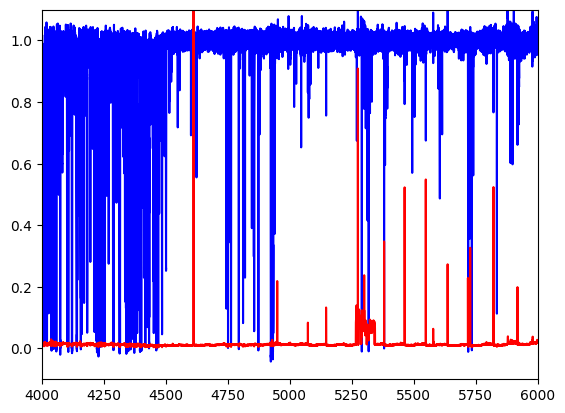

In [2]:
import matplotlib.pyplot as plt
plt.plot(wave,flux,color='b')
plt.plot(wave,err,color='r')
plt.xlim(4000,6000)
plt.ylim(-0.1,1.1)

0.018761192385096638 0.042857160225447596


(-0.1, 1.1)

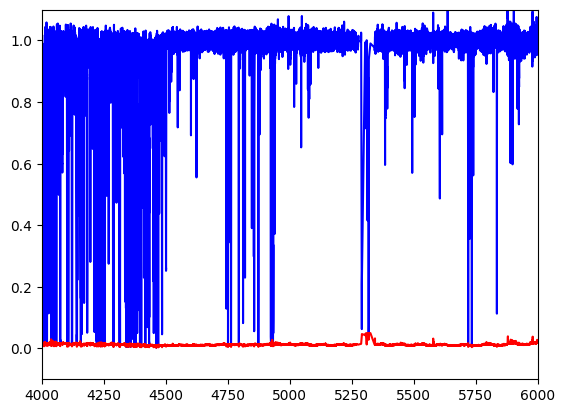

In [3]:
# clean pixels
err_mean = np.mean(err); err_std = np.std(err)
print(err_mean,err_std)
flux1 = flux[(err<0.05)&(flux>0)&(flux>err)]; wave1 = wave[(err<0.05)&(flux>0)&(flux>err)]; err1 = err[(err<0.05)&(flux>0)&(flux>err)]
plt.plot(wave1,flux1,color='b')
plt.plot(wave1,err1,color='r')
plt.xlim(4000,6000)
plt.ylim(-0.1,1.1)

In [4]:
def detect_absorption_lines(wavelengths, flux, threshold=0.9, min_width=5):
    """
    Detect absorption lines in a spectrum and find their midpoints.

    Parameters:
    wavelengths (array-like): Array of wavelength values.
    flux (array-like): Array of normalized flux values corresponding to the wavelengths.
    threshold (float): Flux value below which absorption is detected. Default is 1.0.
    min_width (int): Minimum number of consecutive points below the threshold to be considered significant. Default is 5.

    Returns:
    list of tuples: Each tuple contains the start, end, and midpoint wavelengths of an absorption line.
    """
    absorption_lines = []
    start_idx = None

    for i, f in enumerate(flux):
        if f < threshold:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None:
                if i - start_idx >= min_width:
                    start_wavelength = wavelengths[start_idx]
                    end_wavelength = wavelengths[i-1]
                    midpoint = (start_wavelength + end_wavelength) / 2
                    absorption_lines.append((start_wavelength, end_wavelength, midpoint))
                start_idx = None

    # Handle the case where the absorption line goes till the end of the array
    if start_idx is not None and len(flux) - start_idx >= min_width:
        start_wavelength = wavelengths[start_idx]
        end_wavelength = wavelengths[-1]
        midpoint = (start_wavelength + end_wavelength) / 2
        absorption_lines.append([start_wavelength, end_wavelength, midpoint])

    return absorption_lines

lines=(detect_absorption_lines(wave1,flux1))

(3500.0, 3560.0)

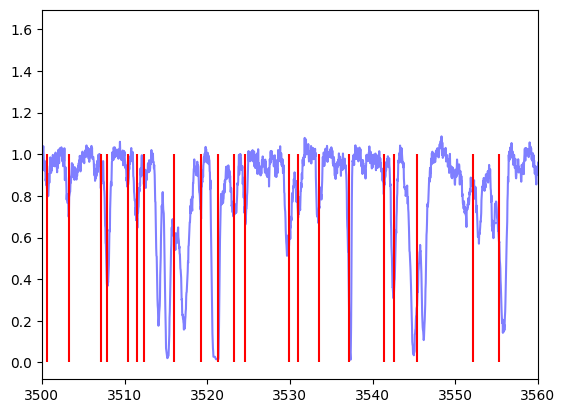

In [5]:
mid = []
for i in range(len(lines)):
    mid.append(lines[i][2])
plt.plot(wave1,flux1,color='blue',alpha=0.5)
plt.vlines(mid,0,1,color='r')
#plt.vlines(lines,0,1,'green')
plt.xlim(3500,3560)

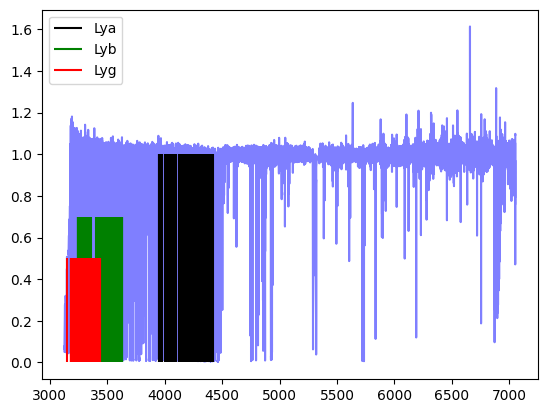

In [6]:
def find_patterns(flux):
    flux = np.array(flux)
    mask = np.ones_like(flux, dtype=bool)  
    patterns = []

    # redshift
    redshift = flux / 1216 - 1

    # Filtering the array and redshift values based on the redshift range
    valid_indices = np.where((redshift > 0) & (redshift < 2.633))[0]
    flux = flux[valid_indices]
    redshift = redshift[valid_indices]
    mask = mask[valid_indices]  

    # Sort array from largest to smallest and get sorted indices
    sorted_indices = np.argsort(flux)[::-1]

    for i in sorted_indices:
        if not mask[i]:
            continue

        z = redshift[i]
        lybeta = 1026 * (1 + z)
        lygamma = 972 * (1 + z)
        wiggle = 100

        # Check for lybeta and lygamma within a range
        found1 = np.where((flux >= lybeta - wiggle) & (flux <= lybeta + wiggle) & mask)[0]
        found2 = np.where((flux >= lygamma - wiggle) & (flux <= lygamma + wiggle) & mask)[0]

        if len(found1) > 0 and len(found2) > 0:
            # Mark the found pattern as masked
            mask[i] = False
            mask[found1[0]] = False
            mask[found2[0]] = False

            # Store the pattern
            patterns.append((z, flux[i], flux[found1[0]], flux[found2[0]]))

    return patterns


res = find_patterns(mid)
red, lya, lyb, lyg  = zip(*res)  
plt.plot(wave1, flux1, color='blue', alpha=0.5)
plt.vlines(lya, 0, 1, 'k', label='Lya')
plt.vlines(lyb, 0, 0.7, 'green', label='Lyb')
plt.vlines(lyg, 0, 0.5, 'red', label='Lyg')
plt.legend()
plt.show()


In [7]:
res

[(2.632308428387697, 4416.88704891944, 3628.636756484236, 3430.8574823822705),
 (2.6297577167482498,
  4413.785383565872,
  3625.1295339231638,
  3432.7620816446315),
 (2.628640375782444, 4412.426696951452, 3629.7698079704924, 3434.876499301353),
 (2.6250548101609827,
  4408.066649155755,
  3619.663388954581,
  3424.0799041131295),
 (2.620499367452157, 4402.527230821823, 3615.647254308713, 3422.8626100263755),
 (2.6155885781028654,
  4396.555710973084,
  3609.9760583719635,
  3415.4493298081834),
 (2.6052710707949447,
  4384.009622086653,
  3601.1897537774466,
  3405.0534351237598),
 (2.6020052807193053,
  4380.038421354675,
  3596.1020456544766,
  3401.850849853069),
 (2.598898015075573, 4376.2599863318965, 3593.436490027419, 3402.219656545344),
 (2.596370805089666, 4373.186898989034, 3606.1116173687965, 3396.76538977809),
 (2.5929414774126402, 4369.01683653377, 3588.905196012536, 3395.2339145909846),
 (2.5922092836674753,
  4368.12648893965,
  3608.2390777331607,
  3398.0471475237455

In [10]:
res.sort(key=lambda x: x[0])

In [11]:
res

[(2.2474640026020896,
  3948.9162271641408,
  3251.039609318808,
  3251.039609318808),
 (2.250817408651405, 3952.9939689201083, 3248.179032105526, 3248.179032105526),
 (2.2569128328177785,
  3960.4060047064186,
  3247.094649409931,
  3247.094649409931),
 (2.261053347395668, 3965.4408704331327, 3246.75673536704, 3243.914032490391),
 (2.2637412318496017,
  3968.7093379291155,
  3248.756565622656,
  3241.959376993658),
 (2.26425076477862, 3969.328929970802, 3249.7005899983815, 3239.289417301359),
 (2.2695489646500104,
  3975.771541014413,
  3258.0394607059525,
  3233.1008309336075),
 (2.2915985638654313, 4002.583853660364, 3278.347749979085, 3230.032006341387),
 (2.2956690202989933, 4007.533528683576, 3287.5015976146306, 3220.61972568775),
 (2.296798236629392, 4008.9066557413407, 3283.967880825606, 3213.588385726376),
 (2.2986572457142356,
  4011.1672107885106,
  3285.0076247698053,
  3210.830405987571),
 (2.3125469410951682,
  4028.0570803717246,
  3315.7627774811776,
  3210.245656265521

In [ ]:
972.5368*(1.0+)